![Course title](./images/title.png)
<i> Alexey Bochkarev </i> | [🌐 www.bochkarev.io](https://www.bochkarev.io) | [✉ a@bochkarev.io](mailto:a@bochkarev.io)

**Discord:** `co05-как-учить-машины-простые-примеры-про-ml`

# ③ Neural Networks!

Let's make some really hard-to-describe data now.

In [1]:
# data generation
import numpy as np
import pandas as pd

def generate_data():
    X = []; Y = []
    for k in range(1000):
        x1 = np.random.rand()*100.0
        x2 = np.random.rand()*100.0
        if ((x1 > 50) or (x2>50)) and not ((x1>50) and (x2>50)):
            y = 1
        else:
            y =  0
        
        X.append([x1,x2])
        Y.append(y)
    return X, Y
    
#X, Y = generate_data()
#df = pd.DataFrame({'x1':[x[0] for x in X], 'x2':[x[1] for x in X], 'y':Y})
#df.to_csv("./squares.csv")
df = pd.read_csv("./squares.csv")
df.head(10)

,Unnamed: 0,x1,x2,y
0,0,72.538769,58.155387,0
1,1,27.942363,26.423649,0
2,2,74.906589,21.414703,1
3,3,72.404937,22.539980,1
4,4,48.679668,38.812417,0
5,5,70.165887,60.807311,0
6,6,30.223125,56.253951,1
7,7,99.147970,96.495794,0
8,8,69.941868,61.370228,0
9,9,70.724652,64.401706,0


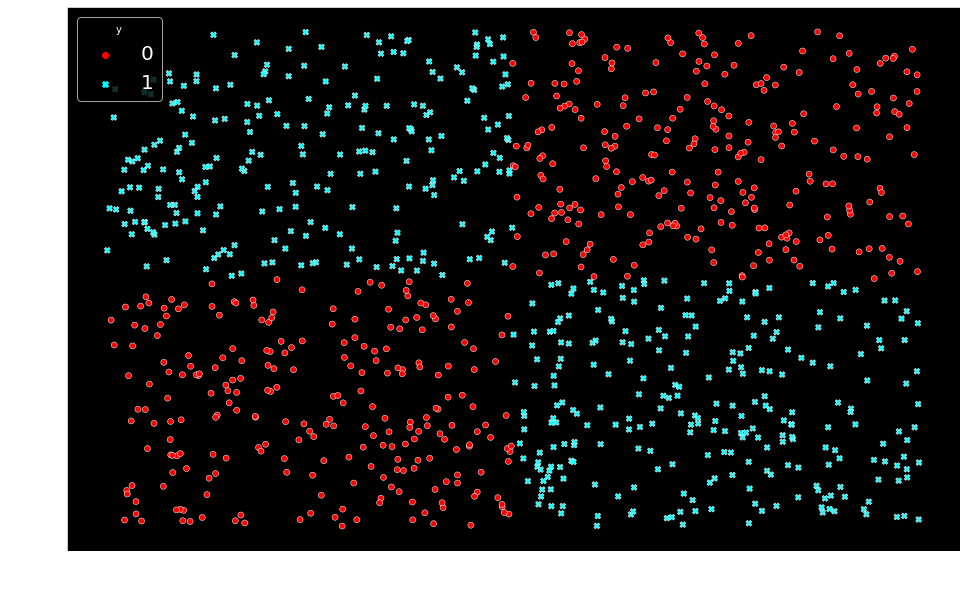

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background"); plt.rc('legend',fontsize=20)
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y",
                palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.show()

## Baseline: quick-and-simple logit

Sometimes it is a good idea to start with a really simple model and see how does it perform...

In [3]:
# Okay, baseline --- let's do Logit!
import statsmodels.api as sm

model = sm.Logit(df['y'], sm.add_constant(df[["x1", "x2"]])).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.692152
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                0.001364
Time:                        21:30:03   Log-Likelihood:                -692.15
converged:                       True   LL-Null:                       -693.10
Covariance Type:            nonrobust   LLR p-value:                    0.3884
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1026      0.170      0.605      0.545      -0.230       0.435
x1             0.0005      0.

Note that the coefficients in `P>|z|` column are relatively large --- this looks like a problem. Let's just try to look what is the model trying to say:

In [4]:
df['baseline_pred_prob'] = model.predict(sm.add_constant(df[["x1", "x2"]]))

threshold = 0.5
df['baseline_pred'] = df['baseline_pred_prob'] >= 0.5

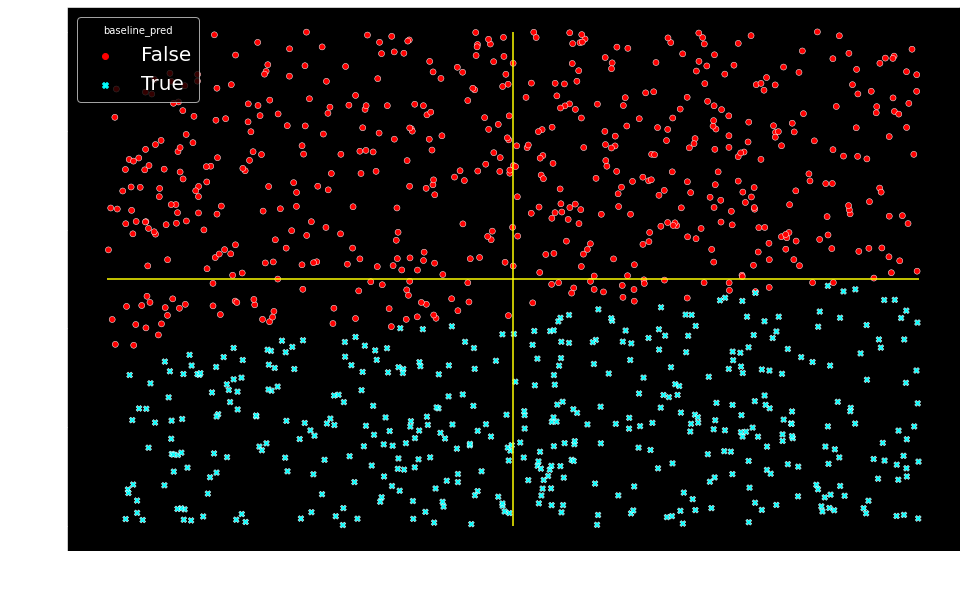

In [5]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="baseline_pred", style="baseline_pred",
               palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

While the bottom-right corner is okay, the top left one is a complete miss. Retrospectively, this is more or less obvious: we were trying to cover NW and SE corners with a single half-plane (which is sort of what a Logit does).

## We obviously need something better.

Hmmm... What if we stacked a few `logit`s together?..

### A "preceptron"

<div>
<img src="images/neuron.png" width="1000"/>
</div>


### ... aaand we can have a few of those:

<div>
<img src="images/NN.png" width="1000"/>
</div>

## How to use it?

1. How to **predict** is relatively clear, right?
*(Blackboard: forward pass)* 

Basically, we just do the following. First, calculate the (intermediate) values of the neurons in the hidden layer:

$$h^1=\sigma(\omega^1_0 + \omega^1_1 x_1 + \omega^1_2 x_2),$$
$$h^2=\sigma(\omega^2_0 + \omega^2_1 x_1 + \omega^2_2 x_2).$$

Then, just get everything together in the output neuron:

$$\textrm{output} = \sigma(\omega^o_0 + \omega^o_1 h^1 + \omega^o_2 h^2),$$

where we use our old friend, sigmoid $\sigma(t)=1/(1+e^{-t})$.

2. But how to **learn**?
*(Blackboard: backward pass)*

This is somewhat more involved, but it essentially boils down to calculating how fast our loss changes if we change the model parameters a little bit. Technically, we calculate derivatives using the chain rule. See also a few other notes in the [PDF](./derivatives.pdf) from our class.

Below, I will implement all this by hand (trying to make it as readable as I can 🤷)

In [6]:
from math import exp

def sigmoid(t):
    """Implements the sigmoid function."""
    return 1/(1+exp(-t))


def sprime(t):
    """Calculates the first derivative of the sigmoid."""
    return 1/(exp(-t)+exp(t)+2)

### Ok, let's implement the forward pass:

In [7]:
def forward(W0, W, x1, x2):
    h = [sigmoid(np.dot(W[j], [1, x1, x2]))
                       for j in range(len(W))]
    
    out = sigmoid(np.dot(W0, [1] + h))
    
    return out, h

def forward_batch(W0, W, x_batch):
    """Calculates predicted y-s for a batch of points."""
    return [forward(W0, W, x[0], x[1]) for x in x_batch]

### Then, the loss:

In [8]:
def batch_loss(y_batch, fwd_batch):
    """Calculates loss for a batch of points."""
    return np.sum([(y_batch[i] - fwd_batch[i][0])**2 for i in range(len(y_batch))])

### ... and the *backpropagation* of errors:

In [9]:
def update_weight(W0, W, fwd_pass_batch, y_batch, x_batch, gamma=0.01):
    """Returns a weight increment."""
    # weight increments
    dW = [np.array([0.0, 0.0, 0.0]) for _ in range(len(W))]
    dW0 = np.array([0.0 for _ in range(len(W0))])
    
    for j in range(len(y_batch)):
        x1, x2 = x_batch[j]
        y_pred, h = fwd_pass_batch[j]
        y = y_batch[j]
        
        # update the out-layer weights
        dW0 -= gamma * 2 * (y_pred - y) * sprime(np.dot(W0, [1] + h)) * np.array(
            [1] + h)
        
        # update the hidden layer weights
        for s in range(len(W)):
            dW[s] -=  gamma * 2 * (y_pred - y) * sprime(np.dot(W0, [1] + h)
                                                   ) * sprime(np.dot(W[s], [1, x1, x2])
                                                             ) * np.array([
                        W0[s+1]*1,
                        W0[s+1]*x1,
                        W0[s+1]*x2])
            
    return np.array(dW), dW0

### Now, how do we *train* the whole thing:

In [10]:
from sklearn.utils import shuffle

def train(X, Y, W0_start, W_start, NO_EPOCHS=100, NO_BATCHES=100):
    W = W_start
    W0 = W0_start
    
    losses = []
    NpB = len(Y) // NO_BATCHES
    
    for epoch in range(NO_EPOCHS):
        loss = 0.0
        X, Y = shuffle(X, Y)

        for b in range(NO_BATCHES):
            x_batch = X[b*NpB:(b+1)*NpB]
            y_batch = Y[b*NpB:(b+1)*NpB].values.tolist()
        
            fwd_batch = forward_batch(W0, W, x_batch)
            
            loss += batch_loss(y_batch, fwd_batch)
            
            dW, dW0 = update_weight(W0, W, fwd_batch, y_batch, x_batch, gamma = 0.005)
            W += dW
            W0 += dW0
        
        losses.append(loss)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} loss: {loss:.1f}")
        
    return W, losses

## Let the magic begin!

**Sidenote:** if you want to play with the model, but don't want to train it for 40 minutes like I did, feel free to just load `W` and `W0` from the file where I saved them after the training (see the end of this notebook for details on how to do that)

In [11]:
from time import time
N_hidden = 2

t0 = time()
W = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(N_hidden)]
W0 = np.array([np.random.rand() - 0.5 for _ in range(N_hidden+1)])
W, losses = train(df[['x1','x2']].values.tolist(), df['y'], W0, W, 50000)
t1 = time()
print(f"Learning finished in {(t1-t0):.1f} sec.")

Epoch 0 loss: 243.1
Epoch 1000 loss: 174.0
Epoch 2000 loss: 175.8
Epoch 3000 loss: 167.1
Epoch 4000 loss: 166.7
Epoch 5000 loss: 166.9
Epoch 6000 loss: 167.4
Epoch 7000 loss: 167.7
Epoch 8000 loss: 167.2
Epoch 9000 loss: 161.6
Epoch 10000 loss: 164.6
Epoch 11000 loss: 160.7
Epoch 12000 loss: 158.2
Epoch 13000 loss: 153.7
Epoch 14000 loss: 141.2
Epoch 15000 loss: 150.9
Epoch 16000 loss: 148.0
Epoch 17000 loss: 143.9
Epoch 18000 loss: 148.4
Epoch 19000 loss: 144.7
Epoch 20000 loss: 151.3
Epoch 21000 loss: 139.6
Epoch 22000 loss: 146.7
Epoch 23000 loss: 143.2
Epoch 24000 loss: 142.1
Epoch 25000 loss: 165.4
Epoch 26000 loss: 147.0
Epoch 27000 loss: 145.2
Epoch 28000 loss: 146.8
Epoch 29000 loss: 145.2
Epoch 30000 loss: 144.9
Epoch 31000 loss: 146.3
Epoch 32000 loss: 141.6
Epoch 33000 loss: 142.3
Epoch 34000 loss: 143.6
Epoch 35000 loss: 151.8
Epoch 36000 loss: 142.3
Epoch 37000 loss: 139.4
Epoch 38000 loss: 143.8
Epoch 39000 loss: 151.1
Epoch 40000 loss: 139.2
Epoch 41000 loss: 142.3
Epoch

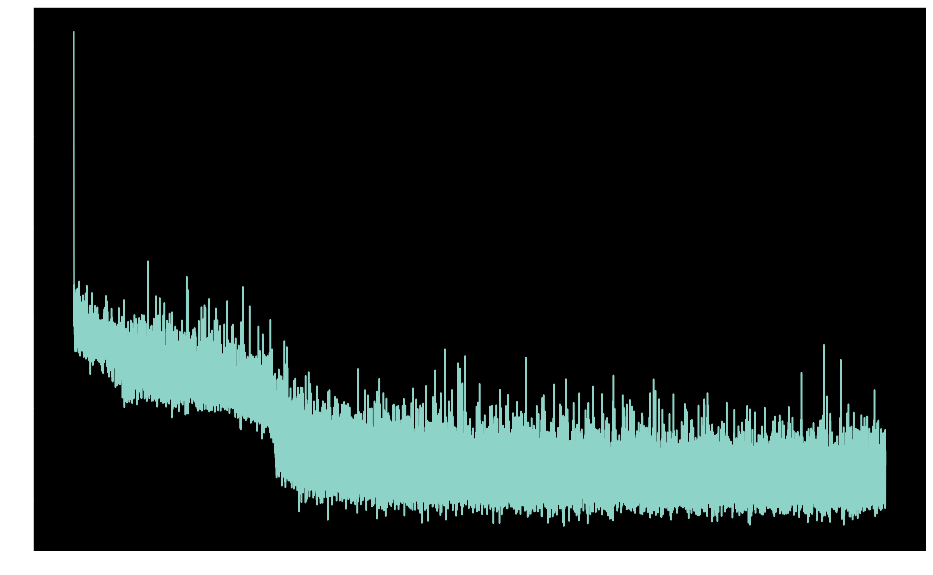

In [12]:
plt.figure(figsize=(16, 10))
plt.plot([j for j in range(len(losses))], losses);plt.show()

Note that the loss was relatively steady until iteration ~ 15,000 --- and then suddenly dropped (perpahs, at that moment the second neuron learned to produce non-trivial outputs).

Now, let us see our predictions:

In [13]:
df['DN_pred_prob'] = [forward(W0, W, df['x1'][i], df['x2'][i])[0] for i in range(len(df))]
df['DN_pred_prob'].head(10)

0    0.196692
1    0.196690
2    0.867395
3    0.867395
4    0.196690
5    0.196690
6    0.196701
7    0.196690
8    0.196690
9    0.196690
Name: DN_pred_prob, dtype: float64

In [14]:
df['DN_pred'] = df['DN_pred_prob'] >= 0.5
df['DN_pred'].head(10)

0    False
1    False
2     True
3     True
4    False
5    False
6    False
7    False
8    False
9    False
Name: DN_pred, dtype: bool

In [15]:
sum(df['DN_pred'])

501

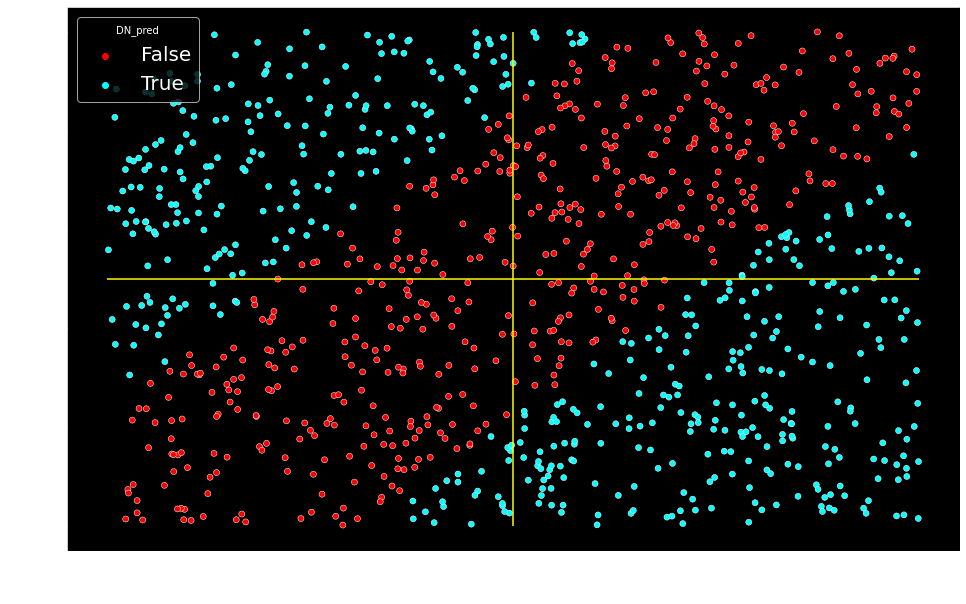

In [16]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="DN_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

That ☝ is pretty good, if you ask me! Now, let us try to figure, how did it manage to capture such a complicated shape. First, let us check when does each neuron activate:

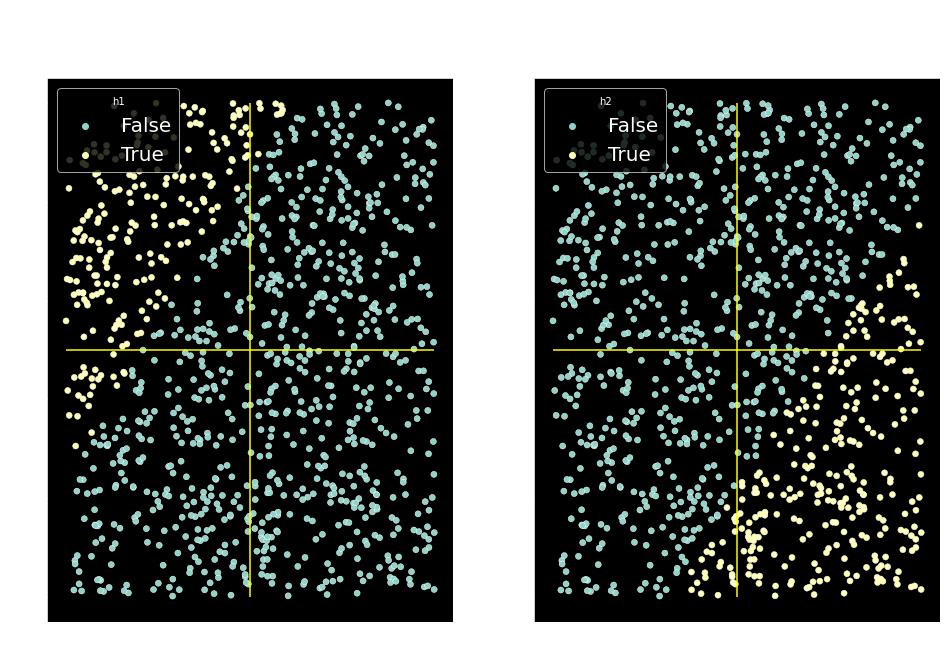

In [17]:
fwd_pass = [forward(W0, W, df['x1'][i], df['x2'][i]) for i in range(len(df))]

for h in range(1, N_hidden + 1):
    df[f"h{h}"] = [fwd_pass[i][1][h-1] >= 0.5 for i in range(len(df))]

fig, ax = plt.subplots(1, N_hidden, figsize=(16,10))
fig.suptitle('Hidden layer activations')

for h in range(1, N_hidden + 1):
    sns.scatterplot(data=df, x="x1", y="x2", hue=f"h{h}",ax=ax[h-1]);
    ax[h-1].hlines(xmin=0, xmax=100, y=[50], color='yellow')
    ax[h-1].vlines(ymin=0, ymax=100, x=[50], color='yellow')
    ax[h-1].set_title(f"Activation of Neuron h{h}", fontsize=22)

Informally speaking, each neuron "learned a concept" of "a good corner." The first one activates around the top left corner, and the second one -- around the bottom right corner. 

Now, the output neuron "sees" only the outputs of the two hidden neurons. It sort of "lives in different coordinates." And in these new coordinates, $h^1$ and $h^2$, a half-plane would totally be OK to get a high quality prediction:

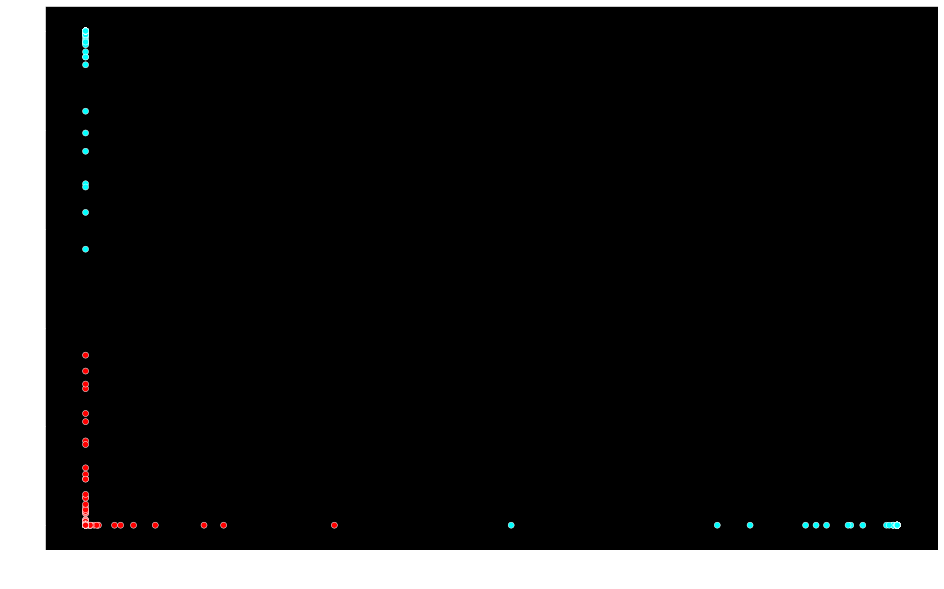

In [18]:
fwd_pass = [forward(W0, W, df['x1'][i], df['x2'][i]) for i in range(len(df))]

df["h1_prob"] = [fwd_pass[i][1][0] for i in range(len(df))]
df["h2_prob"] = [fwd_pass[i][1][1] for i in range(len(df))]

plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="h1_prob", y="h2_prob", hue=f"DN_pred",
                palette=['red', 'cyan']);
plt.gca().get_legend().remove()
plt.show()

Again, informally speaking, this is the super-power of the deep neural networks. They sort of "learn different abstractions." This allows them to approximate really complex stuff --- such as learning the handwritten numbers. Let's check out this example in more detail in the next session.

## A technical note: saving and loading the model

I have saved the weights I got during the training into a binary file as follows:

In [24]:
# Finally: let me save the model
with open("./two-node-network.npy", "wb") as outf:
    np.save(outf, W)
    np.save(outf, W0)

If needed, you can just load these two variables back as follows (don't forget to rename `loaded_W` and `loaded_W0` into just `W` and `W0` if you want to use these values instead of the ones you'd get by training.)

In [25]:
with open("./two-node-network.npy", "rb") as infile:
    loaded_W = np.load(infile)
    loaded_W0 = np.load(infile)

In [27]:
loaded_W

array([[-47.5450992 ,  -2.39815957,   1.94244202],
       [-50.00861282,   1.57505337,  -1.31953459]])

In [28]:
W

array([[-47.5450992 ,  -2.39815957,   1.94244202],
       [-50.00861282,   1.57505337,  -1.31953459]])

In [29]:
loaded_W0

array([-1.40711091,  3.16084199,  3.28523057])

In [30]:
W0

array([-1.40711091,  3.16084199,  3.28523057])